## KMeans Clustering

Using KMeans to identify groupings of players.

Inspiration for this notebook comes from The Athletic's article on the 18 player roles in football.

https://www.nytimes.com/athletic/3473297/2022/08/10/player-roles-the-athletic/

In [2]:
# import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.action_chains import ActionChains
from bs4 import BeautifulSoup
import time
from io import StringIO

In [3]:
# Player_season_stats tables

def fbref_player_season_stats_scrape(url):
    # Set up headless browser
    options = Options()
    options.add_argument("--headless")
    options.add_argument("--disable-gpu")
    driver = webdriver.Chrome(options=options)

    # Load the page
    url = url
    driver.get(url)

    # Wait for the page to load
    time.sleep(5)

    # Scroll to the Player Standard Stats table
    try:
        table_element = driver.find_element(By.ID, "stats_standard")
        actions = ActionChains(driver)
        actions.move_to_element(table_element).perform()
        time.sleep(3)  # let JS populate the table
    except Exception as e:
        print("Could not scroll to table:", e)

    # Get page source
    html = driver.page_source
    driver.quit()

    # Parse the correct table
    soup = BeautifulSoup(html, "html.parser")
    table = soup.find("table", {"id": "stats_standard"})
    if table is None:
        raise Exception("Player Standard Stats table not found in page source!")

    # Convert to DataFrame
    df = pd.read_html(StringIO(str(table)))[0]

    return df

In [4]:
# Cleaning the table

def fbref_player_season_stats_cleaning(df):
    # Make a copy of the original dataframe
    dfa = df.copy()
    
    # Modify the column names from a tuple
    dfa.columns = [col[1] if isinstance(col, tuple) else col for col in dfa.columns]

    # Drop unwanted columns
    dfa.drop(columns = ['Rk', 'Matches'], inplace = True)
    dfa = dfa.iloc[:, :-10]

    # Drop unwanted rows
    dfa.drop(dfa.loc[dfa.Player == 'Player'].index, inplace=True)

    # Modify the 'Nation' entries
    dfa["Nation"] = dfa["Nation"].str[-3:]

    # Modify the 'Position' entries to only be the players' main position
    dfa['Pos'] = dfa['Pos'].replace({'FW,MF':'FW', 'MF,FW':'MF', 'DF,MF':'DF', 'MF,DF':'MF', 'FW,DF':'FW', 'DF,FW':'DF'})

    # Modify the 'Age' entries to be only the first 2 digits
    dfa['Age'] = dfa['Age'].str[0:2]

    # Modify the dtypes of each column
    numerics = ['Age', 'Born', 'MP', 'Starts',
       'Min', '90s', 'Gls', 'Ast', 'CrdY', 'CrdR', 'xG', 'PrgC', 'PrgP', 'PrgR', 'G+A',
               'G-PK', 'PK', 'PKatt', 'npxG', 'xAG', 'npxG+xAG']
    for feature in numerics:
        dfa[feature] = dfa[feature].astype('float')
        
    return dfa

In [5]:
dfa = fbref_player_season_stats_scrape('https://fbref.com/en/comps/9/2024-2025/stats/2024-2025-Premier-League-Stats')
df = fbref_player_season_stats_cleaning(dfa)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 574 entries, 0 to 595
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    574 non-null    object 
 1   Nation    570 non-null    object 
 2   Pos       574 non-null    object 
 3   Squad     574 non-null    object 
 4   Age       571 non-null    float64
 5   Born      571 non-null    float64
 6   MP        574 non-null    float64
 7   Starts    574 non-null    float64
 8   Min       574 non-null    float64
 9   90s       574 non-null    float64
 10  Gls       574 non-null    float64
 11  Ast       574 non-null    float64
 12  G+A       574 non-null    float64
 13  G-PK      574 non-null    float64
 14  PK        574 non-null    float64
 15  PKatt     574 non-null    float64
 16  CrdY      574 non-null    float64
 17  CrdR      574 non-null    float64
 18  xG        574 non-null    float64
 19  npxG      574 non-null    float64
 20  xAG       574 non-null    float64
 21

For this notebook, I'll use stats from the 2024-25 Premier League Season.

I'll trim down the dataset to those who have played more than 1000 minutes to avoid unnecessary clusters around the (0,0) coordinates of any scatter plot.

In [7]:
df = df.loc[df.Min >= 1000].dropna().copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 2 to 595
Data columns (total 25 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Player    303 non-null    object 
 1   Nation    303 non-null    object 
 2   Pos       303 non-null    object 
 3   Squad     303 non-null    object 
 4   Age       303 non-null    float64
 5   Born      303 non-null    float64
 6   MP        303 non-null    float64
 7   Starts    303 non-null    float64
 8   Min       303 non-null    float64
 9   90s       303 non-null    float64
 10  Gls       303 non-null    float64
 11  Ast       303 non-null    float64
 12  G+A       303 non-null    float64
 13  G-PK      303 non-null    float64
 14  PK        303 non-null    float64
 15  PKatt     303 non-null    float64
 16  CrdY      303 non-null    float64
 17  CrdR      303 non-null    float64
 18  xG        303 non-null    float64
 19  npxG      303 non-null    float64
 20  xAG       303 non-null    float64
 21

So the dataset is now cut from 574 entries to just over 300.

Now, we'll want to determine which combination of these stats to cluster on. 

For this notebook, we'll focus on the defenders. 

The Athletic identified 2 main classes - Central and Wide - each with 3 subclasses.

I think that using `PrgR` and `PrgC` would be a good way to breakout central from wide defenders, based on The Athletic's article. 

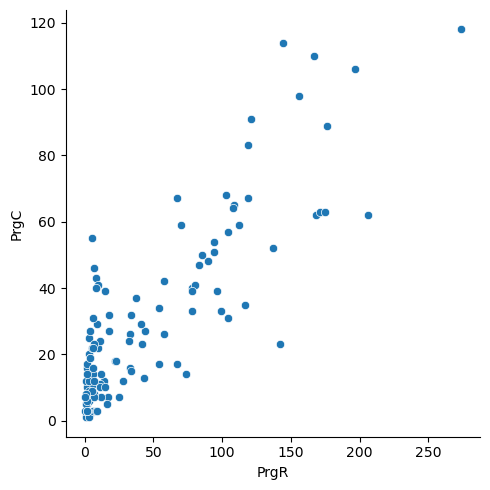

In [9]:
# visualize the scatter plot
sns.relplot(data = df.loc[df.Pos == 'DF'],
           x = 'PrgR',
           y = 'PrgC',
           kind = 'scatter')

plt.show()

It looks like we can see at least two groups, maybe three.

Let's use a knee bend plot and a hierarchy tree to see how best to split this grouping.

In [11]:
# import modules

from sklearn import cluster
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

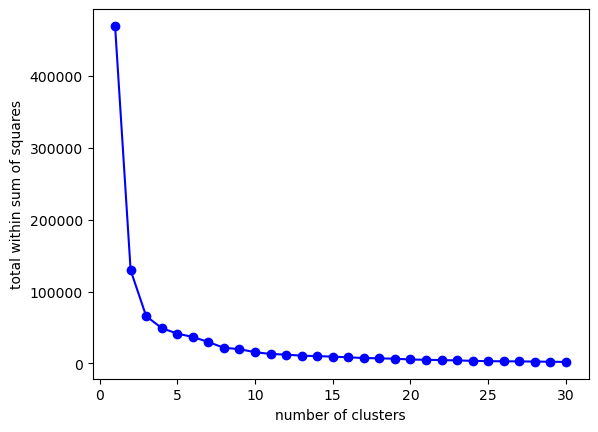

In [12]:
# formally define the data
df_def = df.loc[df.Pos == 'DF'].copy()


# knee bend data

tots_within = []
K = range(1,31)
for k in K:
    km = cluster.KMeans(n_clusters=k, random_state=5000, n_init='auto', init='k-means++')
    km = km.fit(df_def[['PrgR', 'PrgC']])
    tots_within.append(km.inertia_)

# knee bend plot figure
fig, ax = plt.subplots()
ax.plot(K, tots_within, 'bo-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')
plt.show()

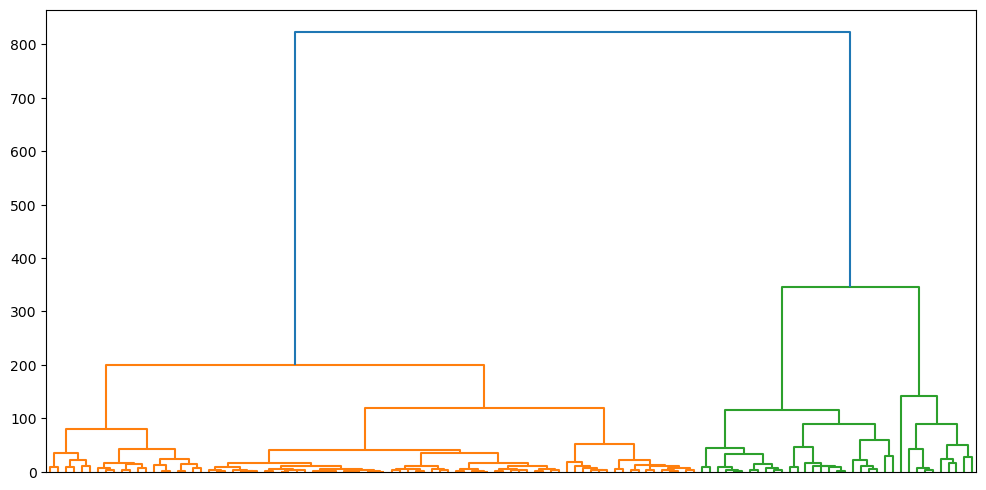

In [13]:
## import module
from scipy.cluster import hierarchy 

## hierarchical cluster
hclust_ward = hierarchy.ward(df_def[['PrgR', 'PrgC']])

## visualize cluster
fig = plt.figure(figsize=(12,6))

dn = hierarchy.dendrogram(hclust_ward, no_labels=True)

plt.show()

So the eye test was pretty good. The knee bend plot suggest two or three groupings would work and the hierarchy suggests two. 

Let's go with 2 for KMeans.

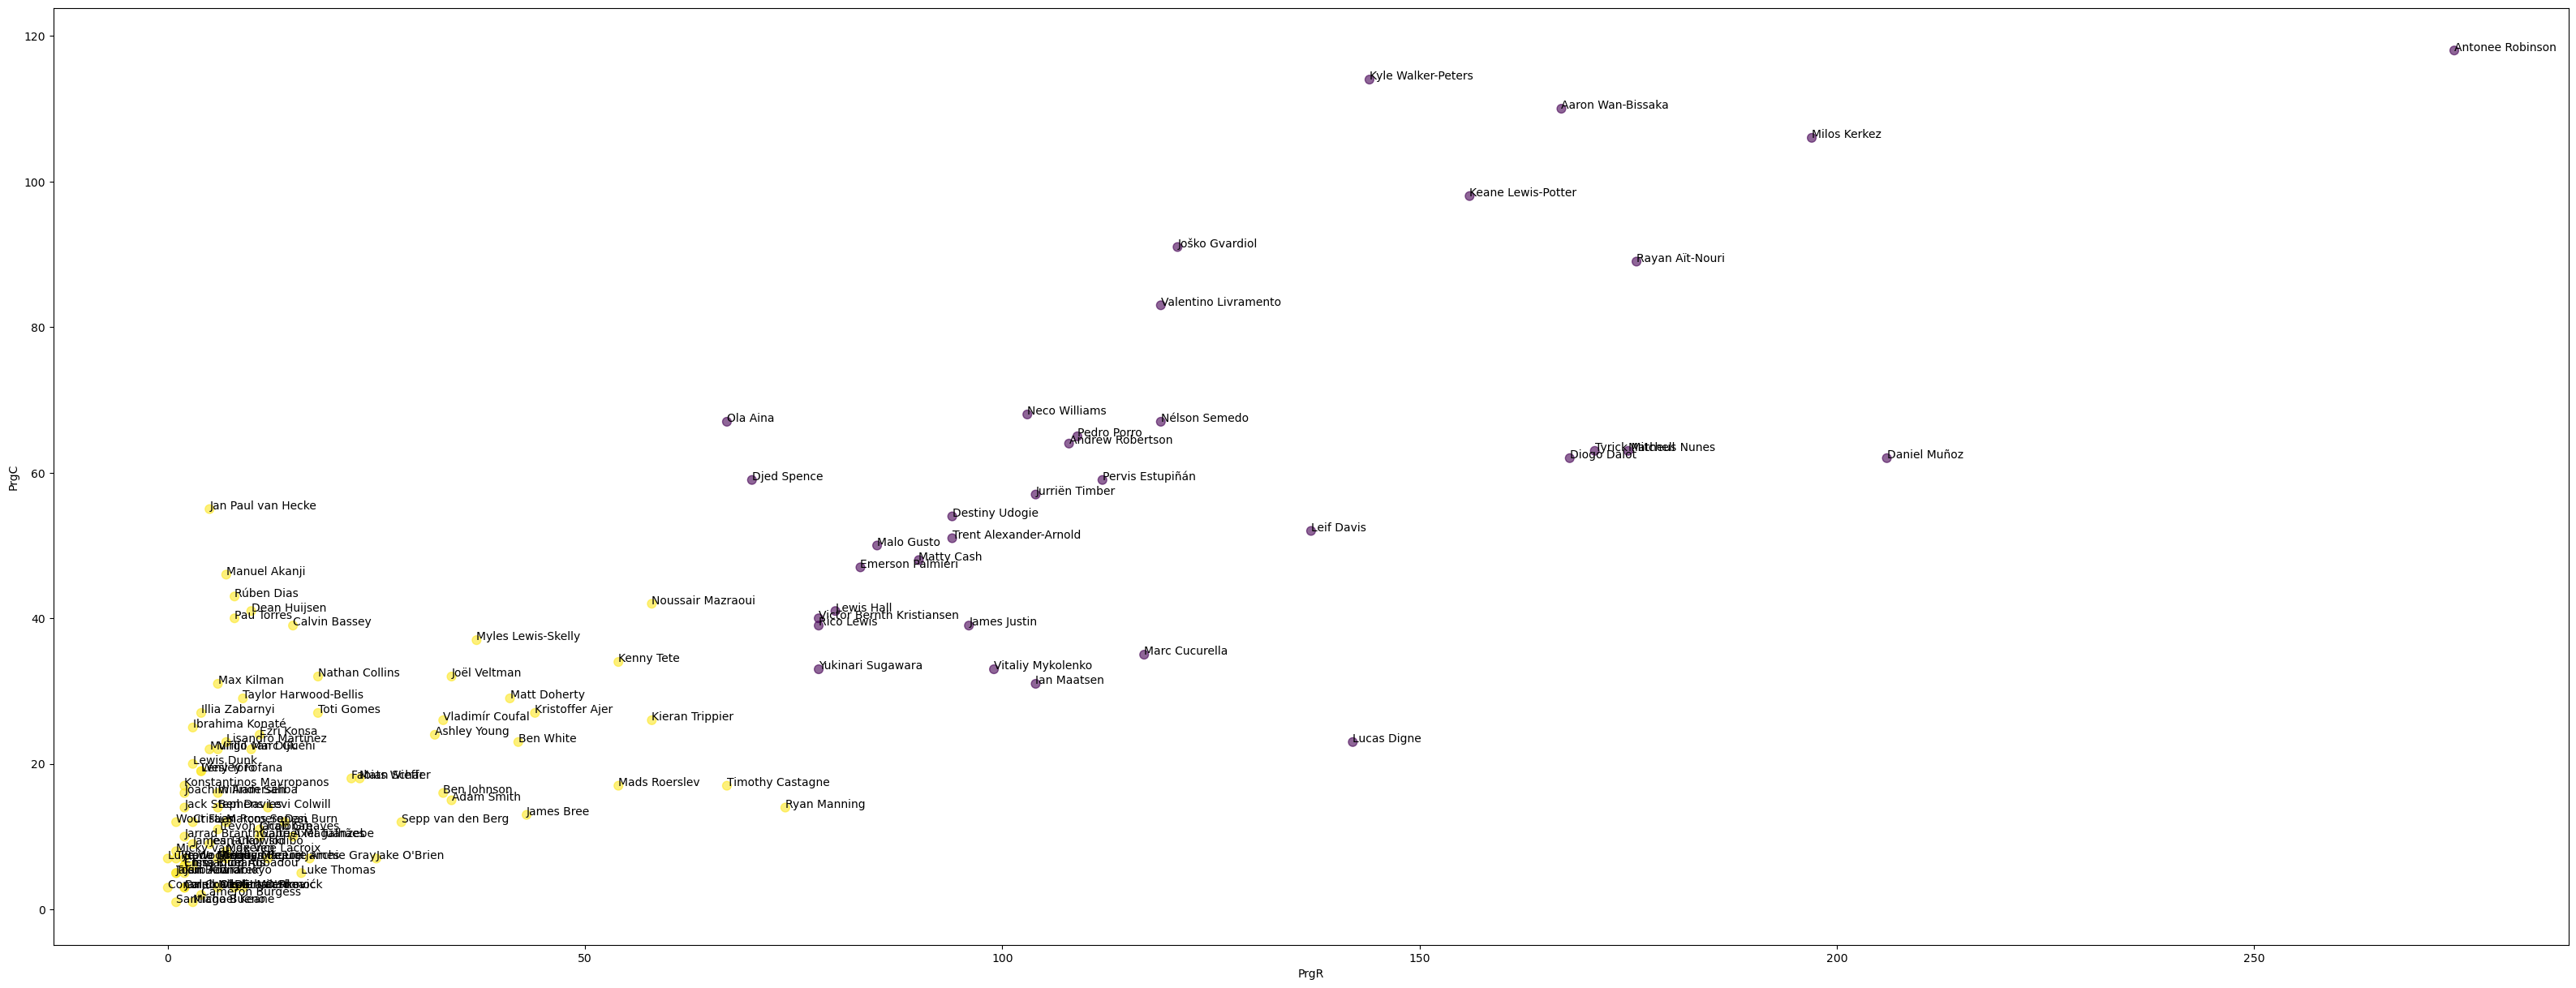

In [15]:
# initialize
k_means = cluster.KMeans(n_clusters=2, init = 'k-means++',\
                         n_init = 'auto', random_state=5000)

# fit
k_means.fit(df_def[['PrgR', 'PrgC']])

# add predictions to dataframe
df_def['pred'] = k_means.labels_

# visualize clustering resluts
fig = plt.figure(figsize=(40,15))
plt.scatter(df_def['PrgR'],df_def['PrgC'],60,c=k_means.labels_, alpha = 0.6)
plt.xlabel('PrgR')
plt.ylabel('PrgC')

[plt.text(row.PrgR, row.PrgC, row.Player) for row in df_def.itertuples()]

plt.show()

While messy, we can see that wide players like Milos Kerkez, Anotonee Robinson, and Marc Crucella were placed in one cluster while Lisandro Martinez and Ibrahima Konaté were placed in the other. 

Wide players like Myles Lewis-Skelly and Ben White who make the occasional progressive run but stay more reserved in their line or in the middle of the field broke out from the cluster of center backs but were ultimately less similar to their attacking wide-back colleagues.

Let's see if we use 3 clusters how these players would fare.

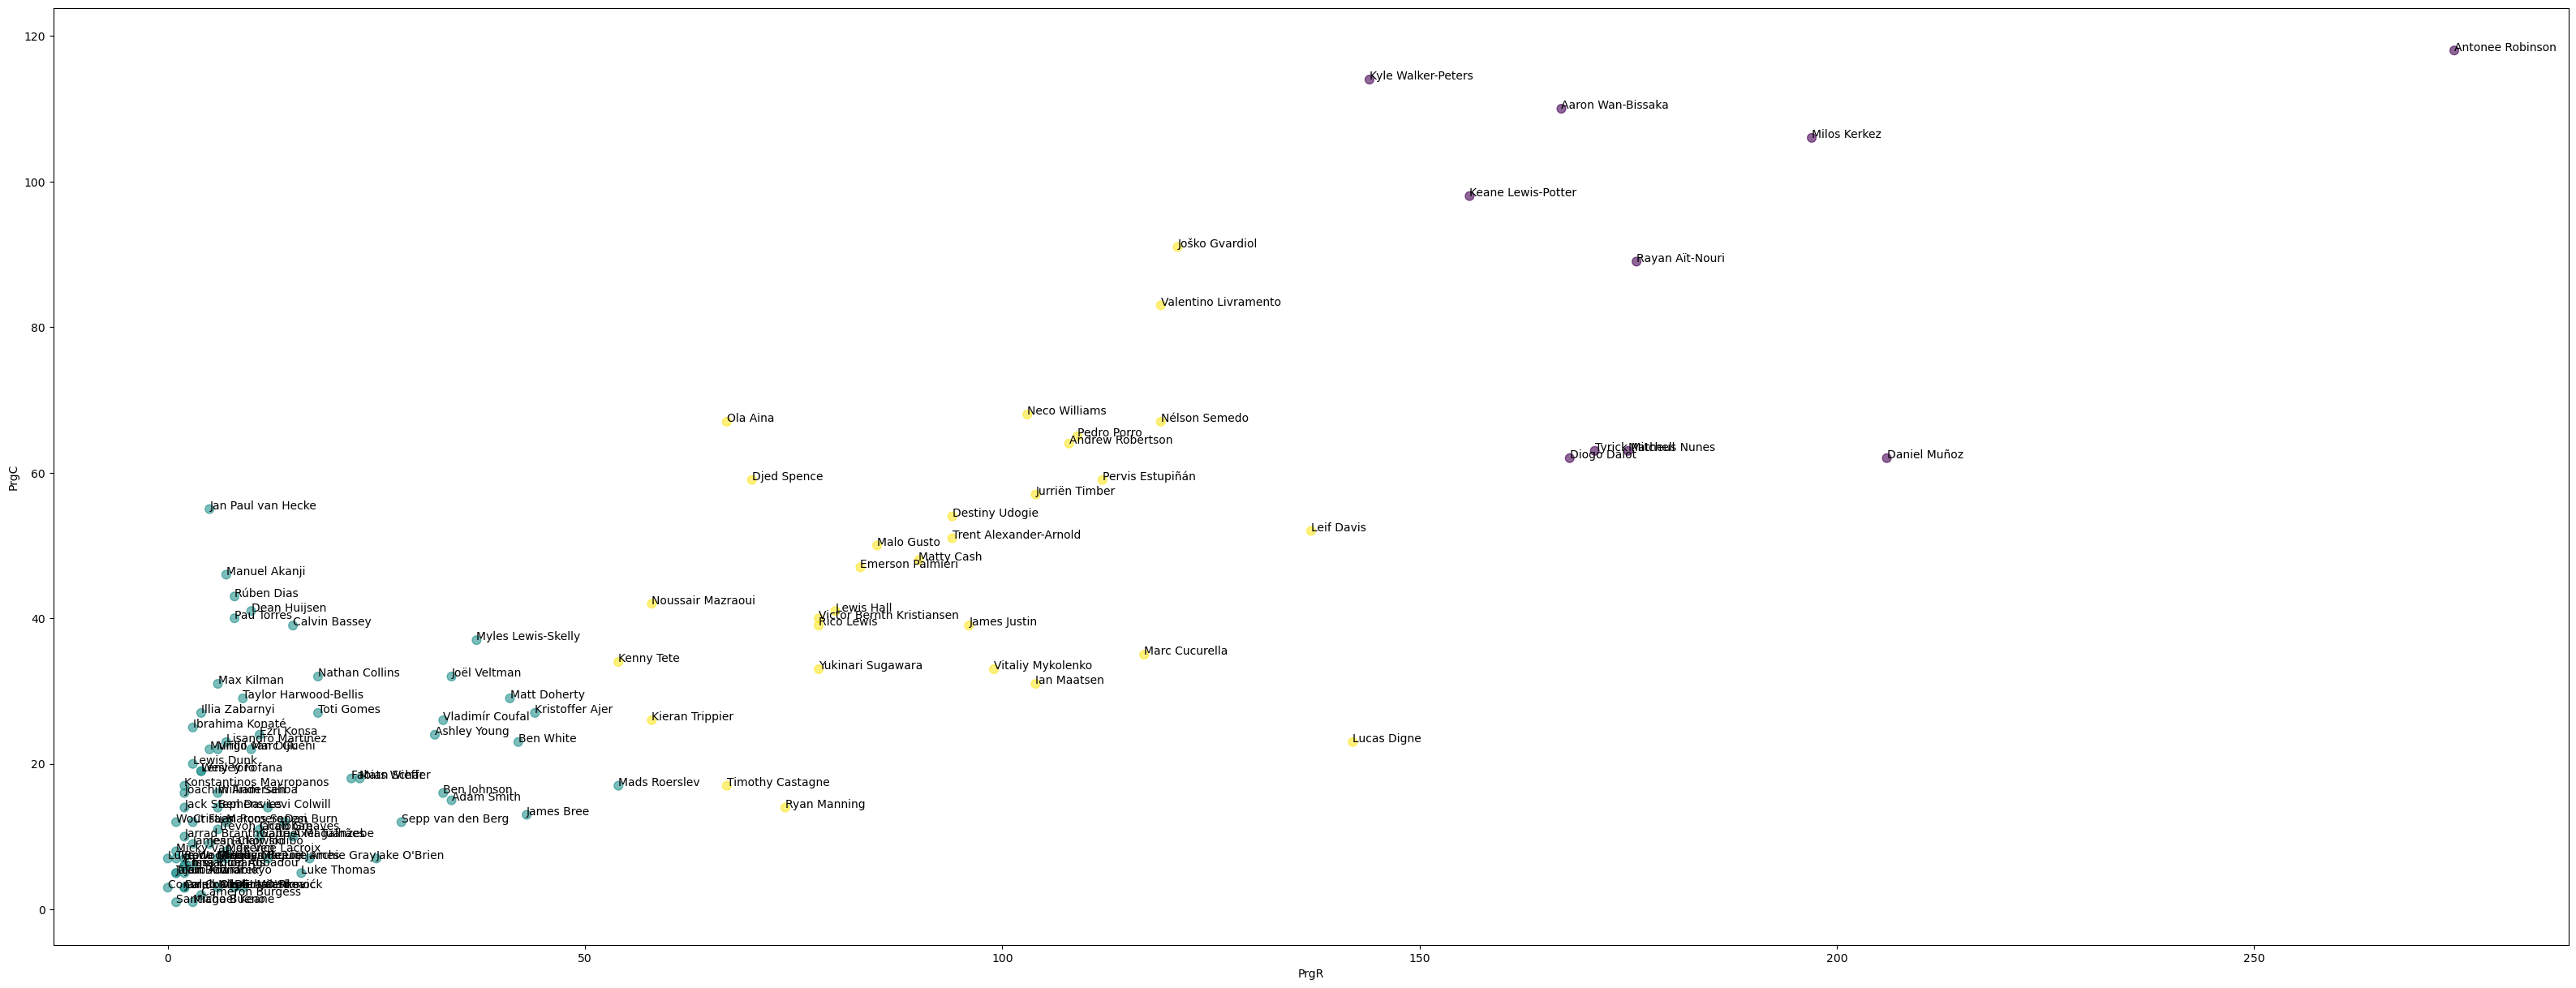

In [17]:
# initialize
k_means = cluster.KMeans(n_clusters=3, init = 'k-means++',\
                         n_init = 'auto', random_state=5000)

# fit
k_means.fit(df_def[['PrgR', 'PrgC']])

# add predictions to dataframe
df_def['pred_3'] = k_means.labels_

# visualize clustering resluts
fig = plt.figure(figsize=(40,15))
plt.scatter(df_def['PrgR'],df_def['PrgC'],60,c=k_means.labels_, alpha = 0.6)
plt.xlabel('PrgR')
plt.ylabel('PrgC')

[plt.text(row.PrgR, row.PrgC, row.Player) for row in df_def.itertuples()]

plt.show()

With three clusters, we're starting to see more separation between the true attacking wide backs and the rest of the group.

From the knee bend plot, there is not much more derived value from adding more clusters, but a deeper analysis looking at more of the variables could show how The Athletic got to their six types of defenders. 

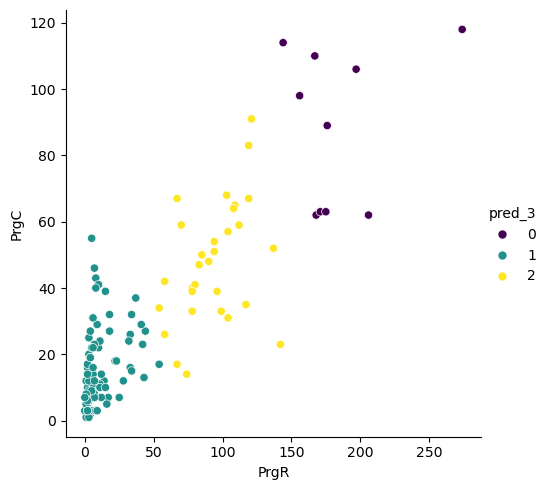

In [33]:
sns.relplot(data = df_def,
           x = 'PrgR',
           y = 'PrgC',
           kind = 'scatter',
           hue = 'pred_3',
           palette='viridis')

plt.show()

In [51]:
df_def

,Player,Nation,Pos,Squad,Age,Born,MP,Starts,Min,90s,...,CrdR,xG,npxG,xAG,npxG+xAG,PrgC,PrgP,PrgR,pred,pred_3
3,Tosin Adarabioyo,ENG,DF,Chelsea,26.0,1997.0,22.0,15.0,1409.0,15.7,...,0.0,0.9,0.9,0.2,1.2,5.0,42.0,1.0,1,1
5,Emmanuel Agbadou,CIV,DF,Wolves,27.0,1997.0,16.0,16.0,1410.0,15.7,...,0.0,0.8,0.8,0.2,1.1,6.0,31.0,2.0,1,1
7,Ola Aina,NGA,DF,Nott'ham Forest,27.0,1996.0,35.0,35.0,2995.0,33.3,...,0.0,0.6,0.6,1.4,2.1,67.0,107.0,67.0,0,2
8,Rayan Aït-Nouri,ALG,DF,Wolves,23.0,2001.0,37.0,37.0,3109.0,34.5,...,1.0,2.7,2.7,5.5,8.2,89.0,108.0,176.0,0,0
9,Kristoffer Ajer,NOR,DF,Brentford,26.0,1998.0,24.0,17.0,1438.0,16.0,...,0.0,1.0,1.0,1.2,2.2,27.0,56.0,44.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,Neco Williams,WAL,DF,Nott'ham Forest,23.0,2001.0,35.0,28.0,2594.0,28.8,...,0.0,2.3,2.3,1.6,3.9,68.0,89.0,103.0,0,2
587,Luke Woolfenden,ENG,DF,Ipswich Town,25.0,1998.0,15.0,12.0,1187.0,13.2,...,0.0,0.0,0.0,0.0,0.0,7.0,15.0,0.0,1,1
590,Leny Yoro,FRA,DF,Manchester Utd,18.0,2005.0,21.0,12.0,1165.0,12.9,...,0.0,0.7,0.7,0.1,0.8,19.0,52.0,4.0,1,1
591,Ashley Young,ENG,DF,Everton,39.0,1985.0,32.0,19.0,1875.0,20.8,...,1.0,0.3,0.3,2.3,2.6,24.0,90.0,32.0,1,1
